<a href="https://colab.research.google.com/github/AbdulkareemAlkhiary/AbdulkareemAlkhiary.github.io/blob/main/Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import os

import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

from keras.preprocessing.image import load_img
import warnings
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from tensorflow.keras.applications.resnet50 import preprocess_input

import sys
import torch.optim as optim
import tensorflow as tf


# Importing Dataset

To import the dataset, please make sure that **Mask Detection** directory is on your root drive folder.

You may do so by following these steps:

1. Go to Shared with me https://drive.google.com/drive/shared-with-me
2. Right click on **Mask Detection** directory
3. Click Add shortcut to Drive.
4. Select **My Drive**
5. Click Add shortcut.


In [ ]:
# dataset paths
MASK_DETECTION_DIRECTORY="/content/drive/MyDrive/Mask Detection"
MODEL_STORAGE_DIRECTORY="/content/drive/MyDrive/Mask Detection/Models"

# dimensions of our images
IMG_WIDTH, IMG_HEIGHT = 64 , 64

In [ ]:
# dataset paths for each category
os.chdir(f"{MASK_DETECTION_DIRECTORY}/Data/fully_covered")
fully_covered = len(os.listdir())

os.chdir(f"{MASK_DETECTION_DIRECTORY}/Data/not_covered")
not_covered = len(os.listdir())

os.chdir(f"{MASK_DETECTION_DIRECTORY}/Data/partially_covered")
partially_covered = len(os.listdir())

os.chdir(f"{MASK_DETECTION_DIRECTORY}/Data/not_face")
not_face = len(os.listdir())

# Splitting Dataset into Training and Test Set

In [ ]:
data_dir = f"{MASK_DETECTION_DIRECTORY}/Data"
batch_size=32
validation_split=0.2 # set this to the validation split you want
seed = 123

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=seed,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 6621 files belonging to 4 classes.
Using 5297 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=seed,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 6621 files belonging to 4 classes.
Using 1324 files for validation.


# Visualisation and Analysis of the Dataset


['Fully Covered', 'Not Covered', 'Partially Covered', 'Not Face']
[1451, 3664, 392, 1114]


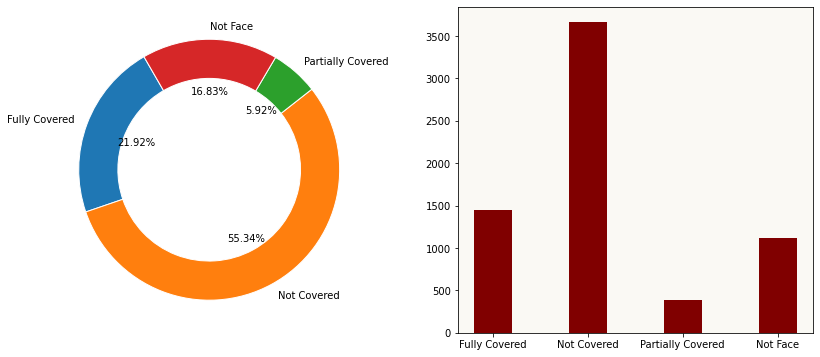

In [ ]:
# https://www.kaggle.com/code/sandhyakrishnan02/face-mask-detection-using-torch

Items = ['Fully Covered', 'Not Covered','Partially Covered','Not Face']
values = [fully_covered, not_covered, partially_covered, not_face]

print(Items)
print(values)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='maroon',width = 0.4)

plt.show()

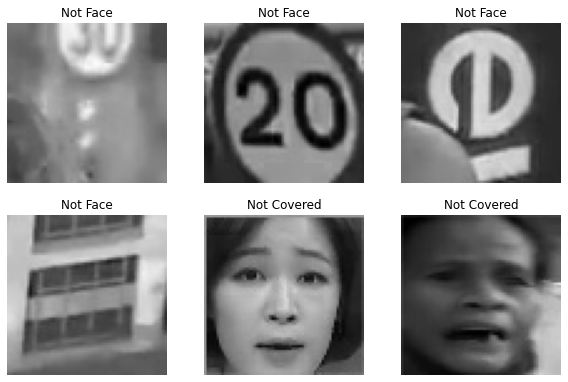

In [ ]:
import matplotlib.pyplot as plt

classnames = ['Fully Covered', 'Not Covered','Not Face','Partially Covered']

# plotting 6 images from our data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classnames[labels[i]])
    plt.axis("off")

# Data Preprocessing and Data Augmentation
In order to make the most of our few training examples, we will "augment" them via a number of random transformations. This helps prevent overfitting and helps the model generalize better.

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class.

[Reference - blog.keras.io](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# https://stackoverflow.com/questions/68873485/tensorflow-load-image-with-image-dataset-from-directory
target_size=(IMG_HEIGHT,IMG_WIDTH) # set this to the target size you want
channels=3 # for color images
color_mode='rgb'
shuffle=True,
seed=123
class_mode=None


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
    validation_split=validation_split)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split)

train_generator  =train_datagen.flow_from_directory(
    data_dir, 
    target_size=target_size, 
    color_mode=color_mode,
    class_mode=class_mode,
    seed=seed,
    batch_size=batch_size,
    subset='training')

validation_generator  =test_datagen.flow_from_directory(
    data_dir, 
    target_size=target_size, 
    color_mode=color_mode,
    class_mode=class_mode,
    seed=seed,
    batch_size=batch_size,
    subset='validation')



Found 5299 images belonging to 4 classes.
Found 1322 images belonging to 4 classes.


# Importing ResNet50 Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, AveragePooling2D


model = ResNet50(
    include_top=False, # set to false to inclide our own input & output layers
    weights="imagenet", # weights that were learnt on the imagenet dataset
    pooling='avg',
    input_shape=(64, 64, 3),
    classes=4,
) 

# Disable training for all of the restnet 50 layers
for layer in model.layers:
	layer.trainable = False

res_model = Sequential()
res_model.add(model)

# Output Layer
res_model.add(Flatten())
res_model.add(Dense(256, activation='relu'))
# res_model.add( Dropout(0.5) )
res_model.add(Dense(4, activation='softmax')) # 4 output neurons

# model architecture
res_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 24,113,284
Trainable params: 525,572
Non-trainable params: 23,587,712
_________________________________________________________________


# Training the Model


Great reference in beginning to understand how to use the training model and transfer learning.

[Reference - Face Mask Detection FastAI](https://www.kaggle.com/code/arbazkhan971/face-mask-detection-using-cnn-98-accuracy/notebook)

In [ ]:
from datetime import datetime
from tensorflow.keras.optimizers import Adam
from keras import metrics


BATCH_SIZE= 32
EPOCHS = 10
INIT_LR = 1e-4

optimizer = Adam(learning_rate=INIT_LR)

# why sparse_categorical: https://www.kaggle.com/general/197993
res_model.compile(optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# train the head of the network
print("[INFO] training head...")
history = res_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# saving the model
print("[INFO] saving mask detector model...")
fitted_model_path=f"{MODEL_STORAGE_DIRECTORY}/{str(datetime.now()).replace(' ', 'T')}"
res_model.save(fitted_model_path, save_format="h5")

[INFO] training head...
Epoch 1/10
166/166 [==============================] - 883s 5s/step - loss: 0.4129 - accuracy: 0.8652 - val_loss: 0.2102 - val_accuracy: 0.9358
Epoch 2/10
166/166 [==============================] - 87s 520ms/step - loss: 0.1412 - accuracy: 0.9526 - val_loss: 0.1701 - val_accuracy: 0.9456
Epoch 3/10
166/166 [==============================] - 86s 519ms/step - loss: 0.0887 - accuracy: 0.9726 - val_loss: 0.1468 - val_accuracy: 0.9486
Epoch 4/10
166/166 [==============================] - 86s 518ms/step - loss: 0.0619 - accuracy: 0.9843 - val_loss: 0.1499 - val_accuracy: 0.9502
Epoch 5/10
166/166 [==============================] - 87s 522ms/step - loss: 0.0440 - accuracy: 0.9894 - val_loss: 0.1368 - val_accuracy: 0.9547
Epoch 6/10
166/166 [==============================] - 86s 519ms/step - loss: 0.0336 - accuracy: 0.9940 - val_loss: 0.1277 - val_accuracy: 0.9569
Epoch 7/10
166/166 [==============================] - 86s 520ms/step - loss: 0.0252 - accuracy: 0.9968 - val

# Model Evaluation

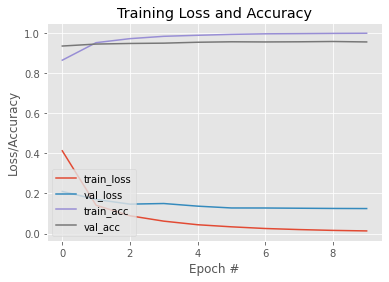

In [ ]:
# plotting the training accuracy/loss
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()